# Movie Summarization using LLMs

### Install Libraries

In [1]:
#!pip -q install langchain openai tiktoken
#!pip install rouge
#!pip install wordcloud

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### Scrape movie script from IMSDB

In [3]:
URL = 'https://imsdb.com/scripts/Joker.html'
FILE_PATH = 'abc.txt'

In [4]:
import requests
from bs4 import BeautifulSoup


url = URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text(separator='\n', strip=True)
    file_path = FILE_PATH  
    
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(text)
else:
    print("Failed to fetch the webpage")

In [5]:
file_path = FILE_PATH  

with open(file_path, 'r', encoding='utf-8') as file:
    news_article = file.read()

Prints the length of the docs list, which represents the total number of Document objects created and, by extension, the number of text chunks the original news_article was split into. This can give you an idea of how many discrete units of text you're working with after the splitting process.

In [6]:
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter

model_name = "gpt-3.5-turbo"

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    model_name=model_name
)

texts = text_splitter.split_text(news_article)

docs = [Document(page_content=t) for t in texts]
print(len(docs))

12


### Add Your Own API Key Here

In [7]:
import sys
import os
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0, openai_api_key=OPENAI_API_KEY, model_name=model_name)

### Prompt Engineering

In [37]:
from langchain.prompts import PromptTemplate

prompt_template = """

Read the {text} carefully, then provide the following output in given schema
[
      ["Summary" "<A detailed summary of the script, should cover the complete story arc of the movie, keep the length between 150 to 200 tokens."],
     [“Keywords”: <Important keywords from the text, with word count of each keyword next to the keyword>]
    ]

"""

prompt = PromptTemplate(template=prompt_template, input_variables=["text"])

### Fetch Number of Tokens

In [38]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.encoding_for_model(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens = num_tokens_from_string(news_article, model_name)
print(num_tokens)

43361


In [39]:
from langchain.chains.summarize import load_summarize_chain
import textwrap
from time import monotonic

gpt_35_turbo_max_tokens = 4097
verbose = True

if num_tokens < gpt_35_turbo_max_tokens:
  #chain = load_summarize_chain(llm, chain_type="stuff", prompt=prompt, verbose=verbose)
  chain = load_summarize_chain(llm, chain_type="stuff", prompt=prompt, verbose=verbose)

else:
  chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=prompt,combine_prompt=prompt, verbose=verbose)

start_time = monotonic()
summary = chain.run(docs)





> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:


Read the The Internet Movie Script Database (IMSDb)
The web's largest
movie script resource!
Search IMSDb
Alphabetical
#
A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z
Genre
Action
Adventure
Animation
Comedy
Crime
Drama
Family
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Short
Thriller
War
Western
Sponsor
TV Transcripts
Futurama
Seinfeld
South Park
Stargate SG-1
Lost
The 4400
International
French scripts
Latest Comments
ALL SCRIPTS
JOKER
AN ORIGIN
Written by

                 Todd Phillips & Scott Silver


                                                  13 April 2018 

  This story takes place in its own universe. It has no
  connection to any of the DC films that have come before it.

  We see it as a classic Warner Bros. movie. Gritty, intimate
  and oddly funny, the characters live in the real world and
  the stakes are personal.

  Although it is never m

In [40]:
print(f"Chain type: {chain.__class__.__name__}")
print(f"Run time: {monotonic() - start_time}")
print(f"Summary: {textwrap.fill(summary, width=100)}")

Chain type: MapReduceDocumentsChain
Run time: 46.35073700000021
Summary: [   ["Summary", "The script follows the story of Joker, a struggling comedian named Arthur Fleck, as
he navigates his way through a bleak and violent Gotham City. He cares for his sick mother and works
as a clown, but faces constant rejection and abuse from society. After a series of unfortunate
events, Arthur descends into madness and becomes the iconic villain, Joker. He questions his
mother's belief that Thomas Wayne, a wealthy man, can help them escape their difficult lives.
Despite his doubts, Joker tries to pursue his comedy career and make his mother proud. However, he
faces setbacks and is eventually fired from his job. Feeling hopeless, Joker contemplates suicide.
He attends an open mic night and performs at a children's hospital, but his prop gun causes trouble
and he is fired from his job as a clown. On the subway, Joker witnesses three obnoxious Wall Street
guys harassing a woman. In a fit of rage, he 

In [41]:
import re
import pandas as pd

# Assuming 'summary' contains your string
# summary = "Your summary string here..."

# Regex pattern to extract the summary text
summary_pattern = r'\["Summary", "(.*?)"\]'
summary_match = re.search(summary_pattern, summary, re.DOTALL)
if summary_match:
    final_summary = summary_match.group(1).replace('\n', ' ').strip()

# Regex pattern to extract the keywords and their counts
keywords_pattern = r'\["Keywords",\s*(.*?)\]\s*\]'
keywords_match = re.search(keywords_pattern, summary, re.DOTALL)
if keywords_match:
    # Find all keyword and count pairs
    keywords_list = re.findall(r'\["(.*?)", (\d+)\]', keywords_match.group(1))

    # Create a DataFrame from the keyword list
    Keywords = pd.DataFrame(keywords_list, columns=['Keyword', 'Count'])



In [42]:
print(f"Chain type: {chain.__class__.__name__}")
print(f"Run time: {monotonic() - start_time}")
#print(f"Summary: {textwrap.fill(summary, width=90)}")

Chain type: MapReduceDocumentsChain
Run time: 46.368989958000384


In [43]:
import re
import pandas as pd

# Assuming 'summary' contains your string
# summary = "Your summary string here..."

# Regex pattern to extract the summary text
summary_pattern = r'\["Summary", "(.*?)"\]'
summary_match = re.search(summary_pattern, summary, re.DOTALL)
if summary_match:
    final_summary = summary_match.group(1).replace('\n', ' ').strip()

# Regex pattern to extract the keywords and their counts
keywords_pattern = r'\["Keywords",\s*(.*?)\]\s*\]'
keywords_match = re.search(keywords_pattern, summary, re.DOTALL)

word_frequencies = {}  # Initialize an empty dictionary for word frequencies

if keywords_match:
    # Find all keyword and count pairs
    keywords_list = re.findall(r'\["(.*?)", (\d+)\]', keywords_match.group(1))

    # Convert the list of tuples into a word_frequencies dictionary
    word_frequencies = {keyword: int(count) for keyword, count in keywords_list}

In [44]:
print(final_summary)

The script follows the story of Joker, a struggling comedian named Arthur Fleck, as he navigates his way through a bleak and violent Gotham City. He cares for his sick mother and works as a clown, but faces constant rejection and abuse from society. After a series of unfortunate events, Arthur descends into madness and becomes the iconic villain, Joker. He questions his mother's belief that Thomas Wayne, a wealthy man, can help them escape their difficult lives. Despite his doubts, Joker tries to pursue his comedy career and make his mother proud. However, he faces setbacks and is eventually fired from his job. Feeling hopeless, Joker contemplates suicide. He attends an open mic night and performs at a children's hospital, but his prop gun causes trouble and he is fired from his job as a clown. On the subway, Joker witnesses three obnoxious Wall Street guys harassing a woman. In a fit of rage, he shoots and kills them. This act sparks a movement against the rich in Gotham City, and Jok

In [45]:
from PIL import Image
import numpy as np

mask_image_path = 'images/batman_bg.png'  
mask_image = Image.open(mask_image_path)
mask_image = mask_image.convert('L')
mask_image = np.array(mask_image)


In [35]:
#fin_summary = 'Set in Gotham City in the 1980s, story describes the life of Arthur Fleck, a struggling stand-up comedian who descends into insanity and turns to a life of crime and chaos becoming an infamous psychopathic criminal as he deals with his mental issues.'

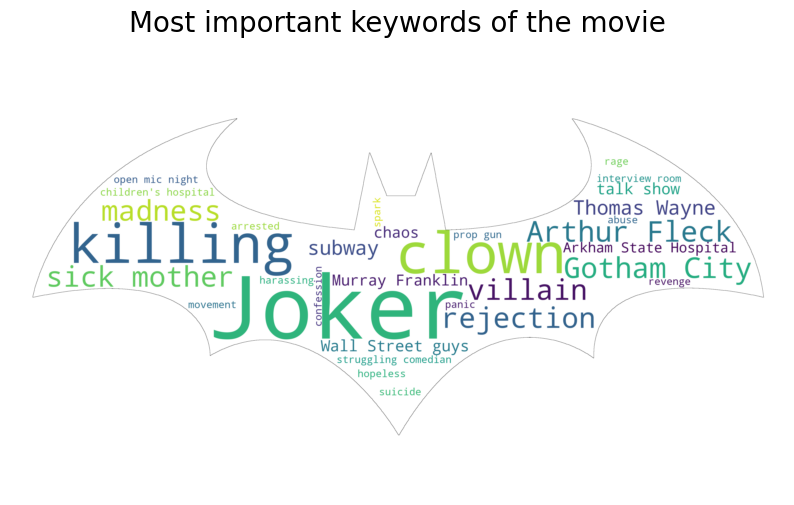

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


wordcloud = WordCloud(background_color='white', mask=mask_image, contour_width=1, contour_color='black')
wordcloud.generate_from_frequencies(word_frequencies)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Most important keywords of the movie', fontsize=20, pad=20)
plt.show()


## Evaluation - Rouge Score

ROUGE-1: Measures the overlap of unigrams (individual words) between the generated and reference summaries.
ROUGE-2: Measures the overlap of bigrams (pairs of consecutive words) between the generated and reference summaries.
ROUGE-L: Measures the longest matching sequence of words using the Longest Common Subsequence (LCS) method, taking sentence structure into account.

In [34]:
# https://www.imdb.com/title/tt7286456/
imdb_summary = 'During the 1980s, a failed stand-up comedian is driven insane and turns to a life of crime and chaos in Gotham City while becoming an infamous psychopathic crime figure.'

In [36]:
from rouge import Rouge


rouge = Rouge()
scores = rouge.get_scores(final_summary, imdb_summary)

print("ROUGE scores:", scores)


ROUGE scores: [{'rouge-1': {'r': 0.7307692307692307, 'p': 0.5135135135135135, 'f': 0.6031745983270346}, 'rouge-2': {'r': 0.5357142857142857, 'p': 0.36585365853658536, 'f': 0.43478260387313594}, 'rouge-l': {'r': 0.6153846153846154, 'p': 0.43243243243243246, 'f': 0.5079365030889393}}]
